# Adaptive network depth

In this notebook we show and example of using the Bayesian skip connections to learn an appropriate network depth from data. Similarly to the `layer_size_toy.ipnb` example, we will use a simple one dimensional regression dataset and fit a fully connected network. The prior belief of the network depth will be encoded in the skip probability of each layer.

In [1]:
import sys

from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import tqdm.notebook as tqdm

In [2]:
sys.path.append("../")

from bal import layers
import utils

For the sake of comparison we use the same regression dataset.

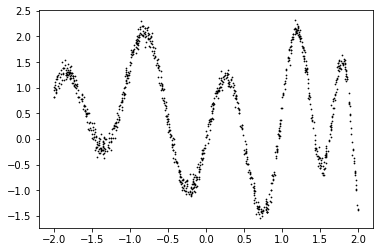

In [36]:
domain = (-2.0, 2.0)
noise_std = 0.1

xs, ys = utils.generate_1d_regression(
    n_points=1000,
    domain=domain, 
    noise_std=noise_std, 
    seed=7
)

plt.scatter(xs.ravel(), ys.ravel(), s=0.5, c='black' )
plt.show()

# We also define a test set which goes beyond the limits in the training set
# and convert the numpy arrays to torch.Tensor types
xs_test = np.linspace(-4.0, 4.0, 200).reshape(-1, 1)
xs_test_t = torch.as_tensor(xs_test, dtype=torch.float32)
xs_t = torch.as_tensor(xs, dtype=torch.float32)
ys_t = torch.as_tensor(ys, dtype=torch.float32)

We construct the network by applying a the skip connections on each layer's input and output. In order to delegate the representation power into the skippable layer, we use linear activation function for the first and last layers. Note that these are the only layers that change the dimensionality and are hence unamenable to the Bayesian skip parameters.

In [37]:
class AdaptiveNet(nn.Module):
    def __init__(self, 
                 in_features, 
                 h_size, 
                 out_features, 
                 n_layers,
                 prior_skip_prob,
                 likelihood_scale):
        super(AdaptiveNet, self).__init__()
        self.n_layers = n_layers
        self.fc1 = nn.Linear(in_features, h_size)
        for i in range(2, self.n_layers+2):
            setattr(self, f"fc{i}", nn.Linear(h_size, h_size))
            setattr(self, f"skip{i}", layers.SkipConnection(prior_skip_prob, temperature=2.0))
        setattr(self, f"fc{n_layers}", nn.Linear(h_size, out_features))
        self.lik = layers.GaussianLikelihood(scale=likelihood_scale)
        self.bayesian_layers = [getattr(self, f"skip{i}") for i in range(2, self.n_layers)]

    def forward(self, inp):
        post = self.fc1(inp)
        pre = post
        for i in range(2, self.n_layers+2):
            post = nn.functional.relu(getattr(self, f"fc{i}")(pre))
            pre = getattr(self, f"skip{i}")(pre, post)
        out = getattr(self, f"fc{self.n_layers}")(pre)
        return out

    def log_likelihood(self, xs, ys):
        params = self.forward(xs)
        logprobs = self.lik(params).log_prob(ys)
        return logprobs
    
    def kl_qp(self, n_samples=1, scale=1.0):
        kls = []
        for bl in self.bayesian_layers:
            kls.append(bl.kl_posterior_prior(n_samples))
        return scale * torch.sum(torch.stack(kls))

In [38]:
def run_step(xs_t, ys_t, opt, net, kl_scale=1.0):
    opt.zero_grad()
    ll = torch.mean(net.log_likelihood(xs_t, ys_t))
    kl = net.kl_qp(n_samples=1, scale=kl_scale)
    loss = kl - ll
    loss.backward()
    opt.step()
    stats = {
        "loss": float(loss.detach().numpy()),
        "skip_probs": [float(torch.sigmoid(l.var_logit.detach()).numpy()) 
                       for l in net.bayesian_layers]
    }
    return stats

In [39]:
def geometric_discount(n, i):
    return 2 ** (n - i) / (2 ** n - 1)

Since the data can be fit with a single layer of about 20-30 units, as we have seen in the previous example of learnable layer size, we create a network with many small layers, e.g. 5 units each. A single layer will not have enough capacity to represent that training data and other layers will have to be "freed" by reducing the skip probability. 

In [43]:
MAX_SIZE = 5
MAX_LAYERS = 10
PRIOR_SKIP_PROB = 0.99

net = AdaptiveNet(
    in_features=1,
    h_size=MAX_SIZE,
    out_features=1,
    n_layers=MAX_LAYERS,
    prior_skip_prob=PRIOR_SKIP_PROB,
    likelihood_scale=noise_std
)

opt = optim.Adam(net.parameters(), lr=3e-3)

In [44]:
n_epochs = 30000
batch_size = 1000
pbar = tqdm.tqdm(range(n_epochs))
train_history = {"skip_probs": [], "preds": []}
for i in pbar:
    for j, (x_t, y_t) in enumerate(utils.batch_generator(xs_t, ys_t, batch_size, shuffle=True)):
        kl_scale = geometric_discount(len(xs_t) // batch_size, j+1)
        stats = run_step(x_t, y_t, opt, net, kl_scale)
    if i % 300 == 0:
        pbar.set_description_str(
            f"loss: {stats['loss']:4.2f}, " 
            f"skip_probs: {[float(f'{p:3.2f}') for p in stats['skip_probs']]}, "
        )
        train_history["skip_probs"].append(stats["skip_probs"])
        train_history["preds"].append(net(xs_test_t).detach().numpy().squeeze())



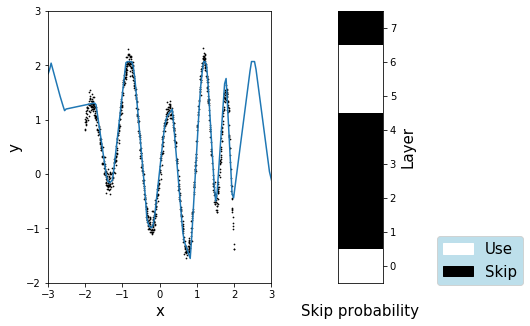

In [45]:
for k, v in train_history.items():
    train_history[k] = np.asarray(v)

ani = utils.animate_skipped_layers(
    data=(xs, ys), 
    predictions=(xs_test, train_history["preds"]), 
    layer_stats=train_history["skip_probs"], 
    max_size=MAX_SIZE, 
    output_path="../network_depth.mp4"
)
HTML(ani.to_html5_video())